In [2]:
!pip install pyhash

     |████████████████████████████████| 604kB 5.1MB/s 
  Created wheel for pyhash: filename=pyhash-0.9.3-cp37-cp37m-linux_x86_64.whl size=2208523 sha256=d5511f2c7357f63221c061aee03a2d8b5d98f301ca5810cbce16ea3c56374907
  Stored in directory: /root/.cache/pip/wheels/0b/6d/31/936fd0c841c52f7afcb77290e2de18fd04d88325853787b36e
Successfully built pyhash


## Imports and Loading dataset

In [70]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pyhash
import random
import matplotlib.pyplot as plt

In [71]:
df = pd.read_csv('drive/MyDrive/train.data', header=None, sep=' ')

In [72]:
df = df.drop([0], axis=1)
df = df.rename(columns={1:'wordIdx', 2:'count'})
df.head()

,wordIdx,count
0,1,4
1,2,2
2,3,10
3,4,4
4,5,2


## Calculating actual frequencies of words

In [73]:
freqs = np.zeros(max(df['wordIdx'])+1)
freqs.shape

(53976,)

In [74]:
n = df.shape[0]
wi = np.array(df['wordIdx'])
c = np.array(df['count'])
for i in range(1,n):
  freqs[wi[i]] += c[i]

In [75]:
freqs = pd.Series(freqs)

In [76]:
freqs

0           0.0
1         313.0
2        1364.0
3         300.0
4         226.0
          ...  
53971       1.0
53972       1.0
53973       1.0
53974       1.0
53975       1.0
Length: 53976, dtype: float64

## MisraGries Sketch

In [77]:
class MisraGries():
  def __init__(self, m, k, idx_name, cnt_name):
    self.m = m
    self.k = k
    self.freq = {}
    self.idx_name = idx_name
    self.cnt_name = cnt_name
    self.n_elems = 0
      
  def process(self, x, cnt):
    if x not in self.freq.copy().keys():
      if self.n_elems < self.k-1:
        self.freq[x] = cnt
        self.n_elems+=1
      else:
        keys = self.freq.copy().keys()
        min_freq = min(self.freq.values())
        if min_freq < cnt:
          min_key = min(self.freq, key=self.freq.get)
          self.n_elems-=1
          self.freq.pop(min_key)
          
          for key in self.freq.copy().keys():
            self.freq[key]-=min_freq
            if self.freq[key]==0:
              self.freq.pop(key)
              self.n_elems-=1
                  
          self.process(x, cnt-min_freq)
        else:
          for key in keys:
            self.freq[key]-=cnt
            if self.freq[key]==0:
              self.n_elems -= 1
              self.freq.pop(key)
    else:
      self.freq[x]+=cnt
          
  def construct(self, df):
    n = df.shape[0]
    idx = np.array(df[self.idx_name])
    cnt = np.array(df[self.cnt_name])
    for i in tqdm(range(n)):
        self.process(idx[i], cnt[i])
          
  def query(self):
    return self.freq

## Count-Min Sketch

In [79]:
class CountMin():
  def __init__(self, d, idx_name, cnt_name, w=5):
    self.w = w
    self.d = d
    self.idx_name = idx_name
    self.cnt_name = cnt_name
    self.A = np.zeros((w,d))
    self.hashfam = [pyhash.super_fast_hash(seed=i) for i in range(self.w)]

  def process(self, x, c):
    for i in range(self.w):
      hash = self.hashfam[i]
      self.A[i, hash(str(x))%self.d] += c

  def construct(self, df):
    n = df.shape[0]
    idx = np.array(df[self.idx_name])
    cnt = np.array(df[self.cnt_name])
    for i in tqdm(range(n)):
      self.process(idx[i], cnt[i])

  def query(self, q):
    ans = self.A[0,self.hashfam[0](str(q))%self.d]
    for i in range(self.w):
      hash = self.hashfam[i]
      ans = min(ans, self.A[i, hash(str(q))%self.d])

    return ans

## Count Sketch

In [82]:
class CountSketch():
  def __init__(self, d, idx_name, cnt_name, w=5):
    self.w = w
    self.d = d
    self.idx_name = idx_name
    self.cnt_name = cnt_name
    self.A = np.zeros((w,d))
    self.hashfam = [pyhash.super_fast_hash(seed=i) for i in range(self.w)]
    self.signhash = [pyhash.super_fast_hash(seed=i) for i in range(self.w)]

  def process(self, x, c):
    for i in range(self.w):
      hash = self.hashfam[i]
      sign = self.signhash[i]
      g = sign(str(x))%2
      if g%2==0:
        g = -1
      else:
        g = 1

      self.A[i, hash(str(x))%self.d] += c*g

  def construct(self, df):
    n = df.shape[0]
    idx = np.array(df[self.idx_name])
    cnt = np.array(df[self.cnt_name])
    for i in tqdm(range(n)):
      self.process(idx[i], cnt[i])

  def query(self, q):
    tmp = []
    for i in range(self.w):
      sign = self.signhash[i]
      g = sign(str(q))%2
      if g%2==0:
        g = -1
      else:
        g = 1
      hash = self.hashfam[i]
      tmp.append(g*self.A[i, hash(str(q))%self.d])

    tmp.sort()
    mid = self.w//2
    if self.w%2==0:
      return (tmp[mid]+tmp[mid-1])/2
    else:
      return tmp[mid]

## Creating Query set

In [85]:
top_1000 = list(freqs.sort_values(ascending=False)[:1000].keys())
query_set = random.sample(top_1000, 100)
print(query_set)

[598, 3132, 5837, 792, 158, 5008, 2111, 1491, 3839, 760, 27145, 1474, 4309, 1951, 597, 1463, 30, 1833, 533, 343, 2305, 5080, 1389, 625, 823, 814, 1690, 555, 2956, 12, 230, 925, 2326, 3970, 141, 16865, 1340, 1440, 399, 89, 5149, 927, 1418, 2444, 1667, 1421, 534, 7340, 16628, 16, 484, 1137, 1217, 1404, 839, 276, 902, 2236, 9399, 86, 308, 996, 5889, 37625, 709, 1099, 3556, 2694, 808, 1653, 1154, 6238, 1073, 9508, 6367, 1135, 1953, 2295, 364, 7993, 1306, 1329, 9175, 7361, 1481, 2857, 192, 3720, 6422, 3950, 4119, 279, 340, 1915, 3232, 750, 1079, 305, 1450, 778]


## Running the sketches on different values of k and calculating errors

In [91]:
k_values = [100, 200, 500, 1000, 2000]

mg_errors = {}
cm_errors = {}
cs_errors = {}


for k in k_values:
  print("[Logs] Running for k = {}".format(k))
  w = 5
  d = k//w

  mg = MisraGries(df.shape[0], k, 'wordIdx', 'count')
  cm = CountMin(d, 'wordIdx', 'count')
  cs = CountSketch(d, 'wordIdx', 'count')

  print("\nCreating Misra Gries", flush=True)
  mg.construct(df)
  print("\nCreating Count Min", flush=True)
  cm.construct(df)
  print("\nCreating Count Sketch", flush=True)
  cs.construct(df)

  mg_results = mg.query()
  
  mg_err = 0
  cm_err = 0
  cs_err = 0

  for q in query_set:
    fmg=0
    if q in mg_results:
      fmg = mg_results[q]
    fcm = cm.query(q)
    fcs = cs.query(q)

    mg_err += abs(fmg-freqs[q])/freqs[q]
    cm_err += abs(fcm-freqs[q])/freqs[q]
    cs_err += abs(fcs-freqs[q])/freqs[q]

  mg_err /=100
  cm_err /=100
  cs_err /=100

  print("\nMG error: ", mg_err)
  print("CM error: ", cm_err)
  print("CS error: ", cs_err)

  mg_errors[k] = mg_err
  cm_errors[k] = cm_err
  cs_errors[k] = cs_err

[Logs] Running for k = 100

Creating Misra Gries


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Creating Count Min


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Creating Count Sketch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




MG error:  0.9888773811628337
CM error:  152.3849868993602
CS error:  205.88347098959142
[Logs] Running for k = 200

Creating Misra Gries




Creating Count Min




Creating Count Sketch




MG error:  0.9836527390022719
CM error:  68.43348173335872
CS error:  96.54780564958169
[Logs] Running for k = 500

Creating Misra Gries




Creating Count Min




Creating Count Sketch




MG error:  0.9648070269036068
CM error:  23.98784298827893
CS error:  36.86894211291587
[Logs] Running for k = 1000

Creating Misra Gries




Creating Count Min




Creating Count Sketch




MG error:  0.9195433008336806
CM error:  10.292291727935513
CS error:  17.204094820159956
[Logs] Running for k = 2000

Creating Misra Gries




Creating Count Min




Creating Count Sketch




MG error:  0.7722839331532305
CM error:  3.9170753970868866
CS error:  7.186924309435896


In [92]:
mg_errors

{100: 0.9888773811628337,
 200: 0.9836527390022719,
 500: 0.9648070269036068,
 1000: 0.9195433008336806,
 2000: 0.7722839331532305}

In [93]:
cm_errors

{100: 152.3849868993602,
 200: 68.43348173335872,
 500: 23.98784298827893,
 1000: 10.292291727935513,
 2000: 3.9170753970868866}

In [94]:
cs_errors

{100: 205.88347098959142,
 200: 96.54780564958169,
 500: 36.86894211291587,
 1000: 17.204094820159956,
 2000: 7.186924309435896}

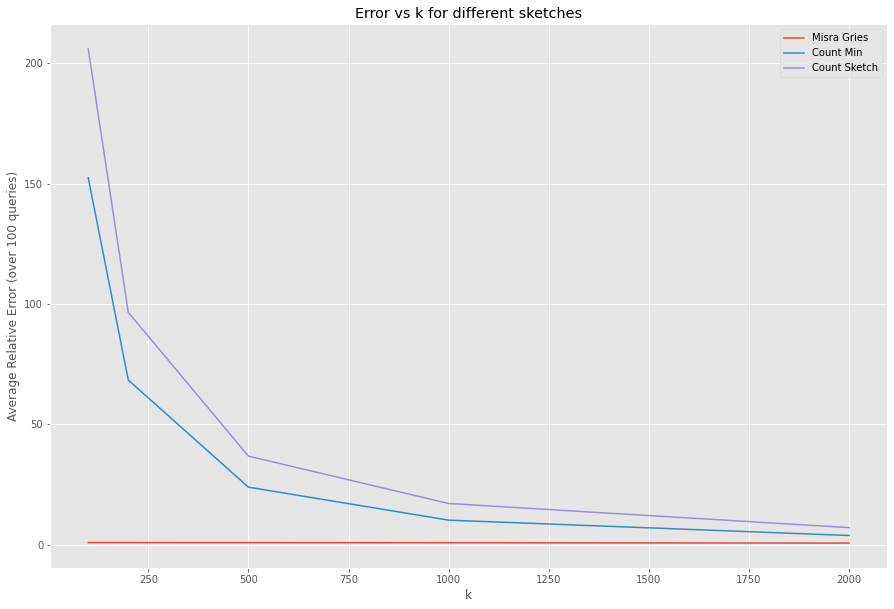

In [95]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
plt.plot(list(mg_errors.keys()), list(mg_errors.values()), label='Misra Gries')
plt.plot(list(cm_errors.keys()), list(cm_errors.values()), label='Count Min')
plt.plot(list(cs_errors.keys()), list(cs_errors.values()), label='Count Sketch')
plt.legend()
plt.title('Error vs k for different sketches')
plt.xlabel('k')
plt.ylabel('Average Relative Error (over 100 queries)')
plt.show()

In [89]:
cm_errors = {}
cs_errors = {}

k = 2500
for w in range(7, 11):
    print("[Logs] Running for w = {}".format(w))
    d = k//w

    cm = CountMin(d, 'wordIdx', 'count')
    cs = CountSketch(d, 'wordIdx', 'count')

    print("\nCreating Count Min", flush=True)
    cm.construct(df)
    print("\nCreating Count Sketch", flush=True)
    cs.construct(df)

    mg_results = mg.query()

    # mg_err = 0
    cm_err = 0
    cs_err = 0

    for q in query_set:
        # fmg=0
        # if q in mg_results:
        #     fmg = mg_results[q]
        fcm = cm.query(q)
        fcs = cs.query(q)

        # mg_err += abs(fmg-freqs[q])/freqs[q]
        cm_err += abs(fcm-freqs[q])/freqs[q]
        cs_err += abs(fcs-freqs[q])/freqs[q]

    # mg_err /=100
    cm_err /=100
    cs_err /=100

    # print("\nMG error: ", mg_err)
    print("CM error: ", cm_err)
    print("CS error: ", cs_err)

    # mg_errors[w] = mg_err
    cm_errors[w] = cm_err
    cs_errors[w] = cs_err

[Logs] Running for w = 7

Creating Count Min


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Creating Count Sketch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CM error:  4.859598627568984
CS error:  1.1327047976989786
[Logs] Running for w = 8

Creating Count Min




Creating Count Sketch



CM error:  5.830650977909995
CS error:  9.673996345015253
[Logs] Running for w = 9

Creating Count Min




Creating Count Sketch



CM error:  6.7422344437666535
CS error:  1.7709725935412735
[Logs] Running for w = 10

Creating Count Min




Creating Count Sketch



CM error:  7.879645268198147
CS error:  12.269540106955827


## Minimum ```w``` for error below 1 %

Misra Gries Sketch: ``` w = 5 ```

Count-Min Sketch: ``` w = 7 ```

Count Sketch: ``` w = 8 ```